# Problématique


Déterminer le rayon d'un produit en fonction de son nom

exemple :



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

# Les données

à quoi ressemblent les données injectées dans le réseau de neurone ?

In [13]:
def auto_encoder_sentences(training_data, testing_data):
    # 10 mots maximum à garder et remplace les mots inconnus avec le token out-of-value
    tokenizer = Tokenizer(num_words=10, oov_token="<OOV>")

    # Crée le dictionnaire
    tokenizer.fit_on_texts(training_data)
    
    print("Dictionnaire : ")
    print(tokenizer.word_index)

    # Les mots sont remplacées par leurs numéros associés
    sequences_training = tokenizer.texts_to_sequences(training_data)
    sequences_testing = tokenizer.texts_to_sequences(testing_data)
    
    print("sequences : ")
    print(sequences_training)
    print(sequences_testing)

    # Ajoute du padding pour que chaque ligne ait la même taille
    padded_training = pad_sequences(sequences_training, padding='post', truncating='pre', maxlen=7)
    padded_testing = pad_sequences(sequences_testing, padding='post', truncating='pre', maxlen=7)
    
    print("sequences + padding")
    print(padded_training)
    print(padded_testing)

    return padded_training, padded_testing

In [14]:
# exemples de phrases, dans notre cas cela sera les noms des produits
sentences_training = {
    "J'ai un chat",
    "J'ai un chien",
    "Ton chien est magnifique"
}

sentences_testing = {
    "J'ai un lapin, il est magnifique"
}

In [15]:
auto_encoder_sentences(sentences_training, sentences_testing)

Dictionnaire : 
{'<OOV>': 1, "j'ai": 2, 'un': 3, 'chien': 4, 'chat': 5, 'ton': 6, 'est': 7, 'magnifique': 8}
sequences : 
[[2, 3, 5], [6, 4, 7, 8], [2, 3, 4]]
[[2, 3, 1, 1, 7, 8]]
sequences + padding
[[2 3 5 0 0 0 0]
 [6 4 7 8 0 0 0]
 [2 3 4 0 0 0 0]]
[[2 3 1 1 7 8 0]]


(array([[2, 3, 5, 0, 0, 0, 0],
        [6, 4, 7, 8, 0, 0, 0],
        [2, 3, 4, 0, 0, 0, 0]]),
 array([[2, 3, 1, 1, 7, 8, 0]]))

Le dictionnaire parcourt toutes les phrases et à chaque fois qu'il en recontre un nouveau, l'ajoute dans son dictionnaire. Ensuite on demande au dictionnaire de remplacer les mots par leurs valeurs associés dans le dictionnaire.

Le dictionnaire n'apprenant pas sur les données de test, il peut y avoir des mots inconnus. Ils sont alors remplacés par la valeur 1 qui représente l'absence de valeur connue(OOV : out of value)

Les valeurs remplacées par des 0 correspond au padding -> indispensable car les données d'inputs (ici les sentences) doivent tous avoir la même taille.

Les exemples pris sont plus simples afin de mieux illustrer comment sont transformées les mots avant d'être injecté dans le réseau de neurones mais normalement on aurait fait le dictionnaire sur les nom des produits (sur données d'entrainement) ce qui donne plus de 10 000 mots différents.

In [4]:
produits = pd.read_csv("produits_carrefour_nomenclatures.csv", sep=';')
name_products = produits['product_name']

tokenizer_produits = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer_produits.fit_on_texts(name_products)


print(tokenizer_produits.word_index)

{'<OOV>': 1, 'de': 2, 'monoprix': 3, 'bio': 4, 'à': 5, 'au': 6, 'et': 7, 'la': 8, 'maison': 9, 'en': 10, '75cl': 11, 'naturalia': 12, 'par': 13, 'gourmet': 14, '250g': 15, 'lait': 16, 'le': 17, 'chocolat': 18, 'sans': 19, 'blanc': 20, 'aux': 21, '1l': 22, '500g': 23, '200g': 24, 'noir': 25, '1': 26, 'du': 27, '100g': 28, '2': 29, 'nature': 30, 'rouge': 31, 'x': 32, 'crème': 33, 'pour': 34, '6': 35, 'aop': 36, 'g': 37, 'sauce': 38, 'extra': 39, 'café': 40, 'vin': 41, 'mois': 42, '4': 43, 'jus': 44, '300g': 45, '3': 46, 'vert': 47, '150g': 48, '400g': 49, 'riz': 50, 'huile': 51, 'pomme': 52, 'citron': 53, '250ml': 54, 'pur': 55, 'dès': 56, '200ml': 57, 'thé': 58, '100': 59, 'gel': 60, 'des': 61, 'mini': 62, '50ml': 63, '5': 64, 'beurre': 65, 'pack': 66, 'poulet': 67, 'eau': 68, '20': 69, 'les': 70, 'petits': 71, 'sachets': 72, 'légumes': 73, '125g': 74, 'anti': 75, 'coco': 76, 'doux': 77, 'fromage': 78, 'fruits': 79, 'shampooing': 80, 'petit': 81, '120g': 82, '500ml': 83, '100ml': 84, 'a

On a 14 835 mots différents pour un peu près 17 000 produits en entrainement ce qui est beaucoup.

Maintenant pour les labels :

Dans mon cas, désirant prédire les rayons je les récupère dans un premier temps.

In [16]:
products = pd.read_csv("produits_carrefour_nomenclatures.csv", sep=';')

labels = products['hypDepartmentDesc']

In [17]:
def number_to_binary(number, size):
    return [0 if i != number else 1 for i in range(size)]


def auto_encoder_y(label_name):
    possibilities = label_name.unique()
    print("Tous les rayons possibles : ")
    print(possibilities)
    size = possibilities.shape[0]

    result = []
    words = {possibilities[i]: i for i in range(size)}
    print("\nDictionnaire : ")
    print(words)

    for l in label_name:
        nb = words[l]
        val = number_to_binary(nb, size)
        result.append(val)
        
    print("\n\nexemple : ")
    print(label_name[0])
    print("\nAprès sa transformation il passe en numéro : ")
    print(words[label_name[0]])
    print("\npuis on le transforme en un vecteurs de n dimension (n = nb de rayons) ou il vaut 1 pour son indexe associé 0 sinon")
    print(result[0])
    
    # return result

In [18]:
auto_encoder_y(labels)

Tous les rayons possibles : 
['EPICERIE' 'BOISSONS' 'P.L.S.' 'PARFUMERIE HYGIENE' 'FRUITS ET LEGUMES'
 'DROGUERIE' 'CONFORT DE LA MAISON' nan 'CHARCUT.TRAITEUR' 'POISSONNERIE'
 'LINGE DE MAISON' 'BOUCHERIE VOLAILLE' 'BRICOLAGE' 'PAPETERIE'
 'JOUET SPORT' 'HOMME' 'FEMME' 'ENFANT' 'ACCESSOIRES' 'LIBRAIRIE'
 'PARAPHARMACIE' 'BOULANGERIE/PATISSERIE' 'CAFETERIA ESPACE RESTAURATION'
 'PEM' 'JARDIN ET ANIMALERIE' 'RADIOTELEPHONIE' 'MICRO INFORMATIQUE'
 'IMAGE ET SON' 'PHOTO COMMUNICATION']

Dictionnaire : 
{'EPICERIE': 0, 'BOISSONS': 1, 'P.L.S.': 2, 'PARFUMERIE HYGIENE': 3, 'FRUITS ET LEGUMES': 4, 'DROGUERIE': 5, 'CONFORT DE LA MAISON': 6, nan: 7, 'CHARCUT.TRAITEUR': 8, 'POISSONNERIE': 9, 'LINGE DE MAISON': 10, 'BOUCHERIE VOLAILLE': 11, 'BRICOLAGE': 12, 'PAPETERIE': 13, 'JOUET SPORT': 14, 'HOMME': 15, 'FEMME': 16, 'ENFANT': 17, 'ACCESSOIRES': 18, 'LIBRAIRIE': 19, 'PARAPHARMACIE': 20, 'BOULANGERIE/PATISSERIE': 21, 'CAFETERIA ESPACE RESTAURATION': 22, 'PEM': 23, 'JARDIN ET ANIMALERIE': 24, 'RAD

# Code & premiers tests

In [2]:
def get_data(f, repartition):
    products = pd.read_csv(f, sep=';')
    
    print("nombre de lignes avant de supprimer celles sans rayon : " + str(products.shape[0]))
    # élimine les preoduits sans nom de rayon associé
    products = products[~products['hypSectorDesc'].isnull()]
    print("nombre de lignes après la supression de celles sans rayon : " + str(products.shape[0]))
    
    x = products['product_name'] # récupérer le nom des produits
    y = products['hypDepartmentDesc'] # récupérer le nom des rayons
    
    print("apercu des données : " + x.head())
    print("apercu des labels : " + y.head())

    print("nombre de données avant la supression des doublons : " + str(len(x)))

    x, y = delete_duplicate(x, y)

    print("nombre de données après la supression de doublons : " + str(len(x)))
    
    # Associe des numéros pour chaque rayon et transforme les numéros en un vecteur binaire
    # ex : 28 rayons, le rayon ayant pour num 0 aura comme vecteur : (1, 0, 0, 0 , ..., 0) le vecteur ayant 28 places car
    # il y a 28 valeurs différentes de y
    y = np.array(auto_encoder_y(y))

    # Sépare en données d'entrainement et de test
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=repartition)
    
    # Convertit les mots en numéro pour analyse par nlp
    x_tr, x_te = auto_encoder_x(x_tr, x_te)
    

    return x_tr, x_te, y_tr, y_te

In [3]:
def auto_encoder_x(training_data, testing_data):
    
    # 20 000 mots maximum à garder et remplace les mots inconnus avec le token out-of-value
    tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

    # Crée le dictionnaire
    tokenizer.fit_on_texts(training_data)

    # Les mots sont remplacées par leurs numéros associés
    sequences_training = tokenizer.texts_to_sequences(training_data)
    sequences_testing = tokenizer.texts_to_sequences(testing_data)

    # Ajoute du padding pour que chaque ligne ait la même taille
    padded_training = pad_sequences(sequences_training, padding='post', truncating='pre', maxlen = 20)
    padded_testing = pad_sequences(sequences_testing, padding='post', truncating='pre', maxlen = 20)

    return padded_training, padded_testing

In [4]:
def number_to_binary(number, size):
    return [0 if i != number else 1 for i in range(size)]

def auto_encoder_y(label_name):
    # Associe des numéros pour chaque rayon et transforme les numéros en un vecteur binaire
    # ex : 28 rayons, le rayon ayant pour num 0 aura comme vecteur : (1, 0, 0, 0 , ..., 0) le vecteur ayant 28 places car
    # il y a 28 valeurs différentes de y
    possibilities = label_name.unique()
    size = possibilities.shape[0]

    result = []
    words = {possibilities[i]: i for i in range(size)}

    for l in label_name:
        nb = words[l]
        val = number_to_binary(nb, size)
        result.append(val)

    return result

In [5]:
def delete_duplicate(x, y):
    df = pd.concat([x, y], axis=1)

    df.drop_duplicates(subset="product_name", keep="first", inplace=True)

    return df["product_name"], df["hypDepartmentDesc"]

In [6]:
model = keras.Sequential([
        Embedding(15000, 128, input_length=20),
        LSTM(64, return_sequences=True),
        LSTM(32, return_sequences=True),
        LSTM(16),
        Dense(64, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dense(32, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dense(28, activation=keras.activations.softmax)
    ])

In [7]:
# Structure du réseau de neurones
def neural_network(batch_size):
    model.summary()

    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy,
                  metrics=keras.metrics.categorical_accuracy)

    logs = model.fit(x_train, y_train, batch_size=batch_size, epochs=150, validation_data=(x_test, y_test)
                     , callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=25), verbose=2)

    return logs

In [8]:
# Afficher les courbes de loss et accuracy à l'aide de matplotlib
def plot_log(all_logs):
    for logs in all_logs:
        losses = logs.history['loss']
        name = logs.history['name'] + " - training"
        plt.plot(list(range(len(losses))), losses, label=name)
        losses = logs.history['val_loss']
        name = logs.history['name'] + " - testing"
        plt.plot(list(range(len(losses))), losses, label=name)
    plt.xlabel("number of epochs")
    plt.ylabel("error")
    plt.title("error on training/testing")
    plt.legend()
    plt.show()

    for logs in all_logs:
        metric = logs.history['categorical_accuracy']
        name = logs.history['name'] + " - training"
        plt.plot(list(range(len(metric))), metric, label=name)
        metric = logs.history['val_categorical_accuracy']
        name = logs.history['name'] + " - testing"
        plt.plot(list(range(len(metric))), metric, label=name)
    plt.xlabel("number of epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("prediction accuracy on training/testing")
    plt.show()

nombre de lignes avant de supprimer celles sans rayon : 36160
nombre de lignes après la supression de celles sans rayon : 36108
0    apercu des données : Kinder Calendrier de l'Av...
1    apercu des données : Lindt Calendrier de l'Ave...
2    apercu des données : Célébrations Calendrier d...
3    apercu des données : Kinder Calendrier De L'Av...
4    apercu des données : M&M'S Calendrier de l'Ave...
Name: product_name, dtype: object
0    apercu des labels : EPICERIE
1    apercu des labels : EPICERIE
2    apercu des labels : EPICERIE
3    apercu des labels : EPICERIE
4    apercu des labels : EPICERIE
Name: hypDepartmentDesc, dtype: object
nombre de données avant la supression des doublons : 36108
nombre de données après la supression de doublons : 21450
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 128)           1920000   
___________________

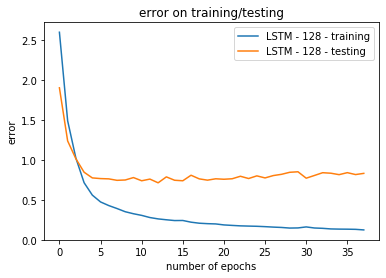

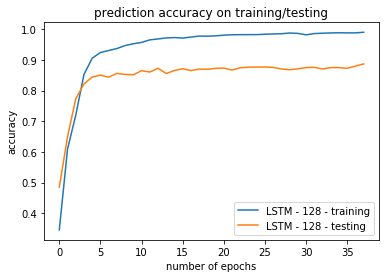

In [9]:
if __name__ == "__main__":
    name_file = "produits_carrefour_nomenclatures.csv"
    batch_size = 128

    all_logs = []

    x_train, x_test, y_train, y_test = get_data(name_file, 0.2)
    

    logs = neural_network(batch_size)

    logs.history['name'] = "LSTM - " + str(batch_size)

    all_logs.append(logs)

    plot_log(all_logs)

On voit un clair overfitting, à la place d'utiliser l2 comme régularisation essayons le dropout : 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           1920000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 48)            33984     
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 48)            18624     
_________________________________________________________________
lstm_5 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

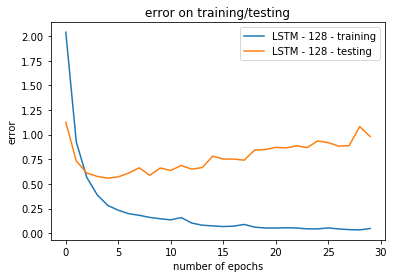

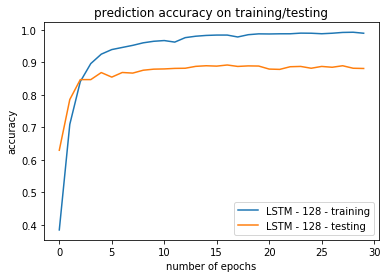

In [10]:
model = keras.Sequential([
        Embedding(15000, 128, input_length=20),
        LSTM(48, return_sequences=True),
        LSTM(48, return_sequences=True),
        LSTM(48),
        Dense(64),
        Dropout(0.40),
        Dense(32),
        Dropout(0.40),
        Dense(28, activation=keras.activations.softmax)
    ])

all_logs = []

logs = neural_network(batch_size)

logs.history['name'] = "LSTM - " + str(batch_size)

all_logs.append(logs)

plot_log(all_logs)

-> pas tellement mieux

cumuler les deux ?

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 128)           1920000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 48)            33984     
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 48)            18624     
_________________________________________________________________
lstm_8 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

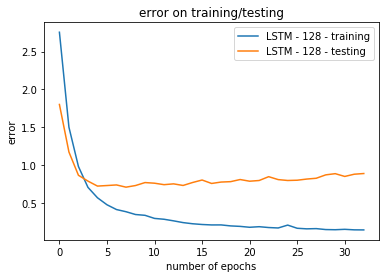

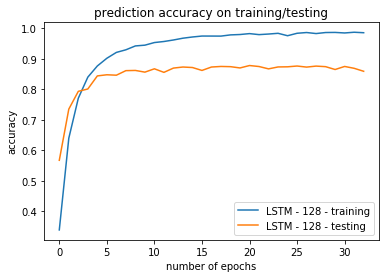

In [11]:
model = keras.Sequential([
        Embedding(15000, 128, input_length=20),
        LSTM(48, return_sequences=True),
        LSTM(48, return_sequences=True),
        LSTM(48),
        Dense(64, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dropout(0.40),
        Dense(32, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dropout(0.40),
        Dense(28, activation=keras.activations.softmax)
    ])

all_logs = []

logs = neural_network(batch_size)

logs.history['name'] = "LSTM - " + str(batch_size)

all_logs.append(logs)

plot_log(all_logs)

-> abaisser le dropout ?

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 128)           1920000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 20, 48)            33984     
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 48)            18624     
_________________________________________________________________
lstm_11 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                3136      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

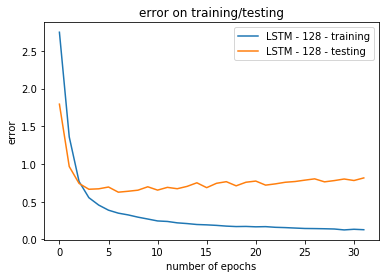

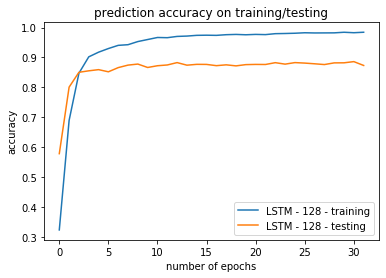

In [12]:
model = keras.Sequential([
        Embedding(15000, 128, input_length=20),
        LSTM(48, return_sequences=True),
        LSTM(48, return_sequences=True),
        LSTM(48),
        Dense(64, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dropout(0.25),
        Dense(32, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dropout(0.25),
        Dense(28, activation=keras.activations.softmax)
    ])

all_logs = []

logs = neural_network(batch_size)

logs.history['name'] = "LSTM - " + str(batch_size)

all_logs.append(logs)

plot_log(all_logs)

-> dropout seul semble être la meilleure méthode